In [1]:
import os
import yaml
import json
import math
import pandas as pd
import pickle
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

import numpy as np

import ase

import torch
import torch.nn as nn
import torch.optim as optim

import schnetpack as spk
import schnetpack.nn as snn
from schnetpack import properties
from schnetpack.interfaces import AtomsConverter
from schnetpack.transform import ASENeighborList

EPS = 1e-8

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(12345)

In [3]:
def get_radial_basis_by_string(radial_basis_type):
    if radial_basis_type == "Bessel":
        return snn.BesselRBF
    elif radial_basis_type == "Gaussian":
        return snn.GaussianRBF

    raise ValueError(f"Unexpected radial basis type:{radial_basis_type}")

def get_cutoff_by_string(cutoff_type):
    if cutoff_type == "cosine":
        return snn.cutoff.CosineCutoff

    raise ValueError(f"Unexpected cutoff type:{cutoff_type}")

## Load conformations

In [4]:
def read_atoms(atoms_path, smiles2number):
    atoms_list = []
    for smiles, number in smiles2number.items():
        atoms_list.append(ase.io.read(f'{atoms_path}/{number}.xyz'))
    return atoms_list

def read_atoms_db(atoms_path, smiles2number):
    atoms_list = []
    for smiles, number in smiles2number.items():
        atoms_list.append(ase.io.read(f'{atoms_path}@{number}'))
    return atoms_list

In [5]:
converter = AtomsConverter(
    neighbor_list=ASENeighborList(cutoff=math.inf),
    dtype=torch.float32,
    device=torch.device("cpu"),
)

### Load molecules

In [23]:
with open("../keys_smiles.yml") as stream:
    try:
        smiles2number_1 = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [25]:
atoms_list = read_atoms_db('../GemNet-OC_test_opt.db', smiles2number_1)

### Load solvent molecules

In [26]:
dataset = pd.read_csv('../train_split_fluor.csv')
solvents = np.unique(dataset['Solvent'])
smiles2number_2 = {}

i = 0
for smi in list(solvents[:-1]):
    smiles2number_2[smi] = i
    i += 1

In [27]:
solvents_list = read_atoms('../xtb_solvents', smiles2number_2)

## Make dataset

In [28]:
def drop_extra(df, columns):
    return df[columns]

def dropna(df):
    return df.dropna(subset=['Absorption max (nm)', 'Emission max (nm)', 'Stokes shift', 'Quantum yield'], how='all')

def replace_gas(df):
    df.loc[df['Solvent'] == 'gas', 'Solvent'] = df['Chromophore']
    return df

def remove_neg_shift(df):
    return df[(df['Stokes shift'] >= 0.0) | (df['Stokes shift'].isna())]

def nm2hz(df):
    df_tmp = df.copy()
    df_tmp.loc[:, 'absorption_freq'] = 3 * 10**(8+9-15) / df_tmp['Absorption max (nm)']
    df_tmp.loc[:, 'emission_freq'] = 3 * 10**(8+9-15) / df_tmp['Emission max (nm)']
    return df_tmp


def make_inv_sig_q_yield(df, eps=1e-5):
    df_tmp = df.copy()
    df_tmp.loc[df_tmp['Quantum yield'] == 0.0, 'Quantum yield'] = eps
    df_tmp.loc[df_tmp['Quantum yield'] == 1.0, 'Quantum yield'] = 1 - eps
    df_tmp.loc[:, 'inv_sig_q_yield'] = np.log(df_tmp['Quantum yield']) - \
                 np.log(1 - df_tmp['Quantum yield'])
    return df_tmp

def delete_outliers(df, columns):
    for column in columns:
        print(column)
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        df = df[
            ((df[column] > q1 - 1.5 * iqr) & (df[column] < q3 + 1.5 * iqr))
            | (df[column].isna())
        ]

        print("left", q1 - 1.5 * iqr)
        print("right", q3 + 1.5 * iqr)
        print("=" * 100)
    return df


def preprocess_train(df):
    df = drop_extra(df, smiles_columns + ['Absorption max (nm)', 'Emission max (nm)',
                                          'Stokes shift', 'Quantum yield'])
    df = dropna(df)
    df = replace_gas(df)
    df = remove_neg_shift(df)
    df = nm2hz(df)
    df = make_inv_sig_q_yield(df)
    # df = delete_outliers(df, target_columns[:-1])
    df = drop_extra(df, smiles_columns + target_columns)
    return df

def preprocess_test(df):
    df = drop_extra(df, smiles_columns + ['Absorption max (nm)', 'Emission max (nm)',
                                          'Stokes shift', 'Quantum yield'])
    df = replace_gas(df)
    df = remove_neg_shift(df)
    df = nm2hz(df)
    df = make_inv_sig_q_yield(df)
    # df = delete_outliers(df, target_columns[:-1])
    df = drop_extra(df, smiles_columns + target_columns)
    return df

In [29]:
data_path = '../train_split_fluor.csv'

smiles_columns = ['Chromophore', 'Solvent']
target_columns = ['absorption_freq', 'emission_freq', 'inv_sig_q_yield']

In [30]:
data_df = pd.read_csv(data_path)

In [31]:
data_clean = preprocess_train(data_df)
data_clean.shape

(18110, 5)

In [32]:
test_data_df = pd.read_csv('../test_split_fluor.csv')
test_data_df.shape

(1850, 16)

In [33]:
test_data_clean = preprocess_test(test_data_df)
test_data_clean.shape

(1847, 5)

In [34]:
def make_dataset(
    data,
    atoms_list,
    solvents_list,
    smiles_columns,
    target_columns,
    smiles2number_1,
    smiles2number_2,
):
    confs = []
    targets = []
    for index, row in data.iterrows():
        atoms_and_solvents = []
        smiles_1 = data.loc[index, smiles_columns[0]]
        smiles_2 = data.loc[index, smiles_columns[1]]
            
        if smiles_1 in smiles2number_1:
            if smiles_2 in smiles2number_2:
                atoms_and_solvents.append(atoms_list[smiles2number_1[smiles_1]])
                atoms_and_solvents.append(solvents_list[smiles2number_2[smiles_2]])

                confs.append(atoms_and_solvents)
                targets.append(data.loc[index, target_columns].to_numpy())
            elif smiles_2 == 'gas':
                atoms_and_solvents.append(atoms_list[smiles2number_1[smiles_1]])
                atoms_and_solvents.append(atoms_list[smiles2number_1[smiles_1]])

                confs.append(atoms_and_solvents)
                targets.append(data.loc[index, target_columns].to_numpy())
    targets = np.array(targets)
    return confs, targets
        

In [35]:
confs, targets = make_dataset(
    data_clean,
    atoms_list,
    solvents_list,
    smiles_columns,
    target_columns,
    smiles2number_1,
    smiles2number_2
)

In [36]:
# место для теста

In [37]:
seed = 12345

train_confs, val_confs, train_targets, val_targets = train_test_split(
    confs,
    targets,
    test_size=0.1,
    random_state=seed
)

In [38]:
target_scaler = StandardScaler()

train_targets = target_scaler.fit_transform(train_targets)
val_targets = target_scaler.transform(val_targets)

In [39]:
target_scaler_coefs = {
    'scale': target_scaler.scale_,
    'mean': target_scaler.mean_
}

with open(f"target_scaler_coefs_{seed}.pkl", "wb") as f:
    pickle.dump(target_scaler_coefs, f)

In [40]:
def confs_targets_to_dset(confs, targets):
    return [[conf, y] for conf, y in zip(confs, targets)]

train_dataset = confs_targets_to_dset(train_confs, train_targets)
val_dataset = confs_targets_to_dset(val_confs, val_targets) 

## Training model

In [113]:
class PaiNNModel(nn.Module):
    def __init__(
        self,
        repr_1,
        repr_2,
        mlp_layers=3,
        mlp_in=256,
        mlp_hidden=256,
        mlp_dropout=0.5,
        mlp_out = len(target_columns)
    ):
        super().__init__()

        self.input_module = spk.atomistic.PairwiseDistances()
        
        self.representation_1 = repr_1
        self.representation_2 = repr_2
        
        self.atomwise_1 = spk.atomistic.Atomwise(
                n_in=self.representation_1.n_atom_basis,
                n_out=mlp_in
        )
        self.atomwise_2 = spk.atomistic.Atomwise(
                n_in=self.representation_2.n_atom_basis,
                n_out=mlp_in
        )

        head_layers = []
        head_layers.append(nn.SELU())
        head_layers.append(nn.Linear(2*mlp_in, mlp_hidden))
        head_layers.append(nn.ReLU())
        head_layers.append(nn.Dropout(mlp_dropout))
        for i in range(mlp_layers-1):
            head_layers.append(nn.Linear(mlp_hidden, mlp_hidden))
            head_layers.append(nn.ReLU())
            head_layers.append(nn.Dropout(mlp_dropout))
        head_layers.append(nn.Linear(mlp_hidden, mlp_out))
        # head_layers.append(nn.SELU())
        # head_layers.append(nn.Linear(2*mlp_in, mlp_out))
        
        self.head = nn.Sequential(*head_layers)

        
    def forward(self, input):
        output_1 = self.input_module(input[0])
        output_2 = self.input_module(input[1])

        output_1 = self.representation_1(output_1)
        output_2 = self.representation_2(output_2)

        output_1 = self.atomwise_1(output_1)
        output_2 = self.atomwise_2(output_2)

        output = torch.cat([output_1['y'], output_2['y']], dim=-1)

        output = self.head(output)
        
        return output
    

In [114]:
def process_atoms(atoms_batch):
    atoms_batch = converter(atoms_batch)
    atoms_batch = {k:v.to(device) for k, v in atoms_batch.items()}
    return atoms_batch

def process_batch(batch):
    batch_size = len(batch)
    atoms_batch = []
    solvents_batch = []
    targets = np.zeros((batch_size, len(target_columns)))
    for i in range(batch_size):
        atoms_batch.append(batch[i][0][0])
        solvents_batch.append(batch[i][0][1])
        targets[i, :] = batch[i][1]

    atoms_batch = process_atoms(atoms_batch)
    solvents_batch = process_atoms(solvents_batch)
    targets = torch.tensor(targets, dtype=torch.float32).to(device)
    return ((atoms_batch, solvents_batch), targets)
    

In [115]:
def masked_mse_loss(predictions, targets):
    mask = ~torch.isnan(targets)
    
    masked_predictions = predictions[mask]
    masked_targets = targets[mask]
    
    mse_loss = nn.functional.mse_loss(masked_predictions, masked_targets)

    return mse_loss

In [116]:
class SaveBestModel:
    def __init__(self, save_dir, best_value=None):
        self.save_dir = save_dir
        
        if best_value is None:
            self.best_value = float('inf')
        else:
            self.best_value = best_value

        self.last_checkpoint_path = None

    def __call__(self, model, current_value,
                 epoch, optimizer, scheduler,
                 train_loss_history, val_loss_history):
        if current_value < self.best_value:
            self.best_value = current_value

            state = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss_history': train_loss_history,
                'val_loss_history': val_loss_history,
            }

            save_path = os.path.join(self.save_dir, f'epoch={epoch}-loss={self.best_value:.4f}.pt')
            torch.save(state, save_path)

            if self.last_checkpoint_path is not None and os.path.exists(self.last_checkpoint_path):
                os.remove(self.last_checkpoint_path)

            self.last_checkpoint_path = save_path


In [129]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    loss_fn,
    optimizer,
    scheduler,
    save_best_model,
    num_epochs=5,
    batch_size=32
):
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        random.shuffle(train_dataset)
        
        total_train_loss = 0.0
        n_iters = 0
        for i in tqdm(range(0, len(train_dataset), batch_size)):
            optimizer.zero_grad()
            
            batch = train_dataset[i:i + batch_size]
            batch = process_batch(batch)
            inputs, targets = batch[0], batch[1]
                        
            predictions = model(inputs)
            loss = loss_fn(predictions, targets)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            n_iters += 1
        avg_train_loss = total_train_loss / n_iters
        train_loss_history.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0.0
        n_iters = 0
        with torch.no_grad():
            for i in range(0, len(val_dataset), batch_size):
                batch = val_dataset[i:i + batch_size]
                batch = process_batch(batch)
                inputs, targets = batch[0], batch[1]
                
                predictions = model(inputs)
                loss = loss_fn(predictions, targets)
                
                total_val_loss += loss.item()
                n_iters += 1
        avg_val_loss = total_val_loss / n_iters
        val_loss_history.append(avg_val_loss)

        scheduler.step(avg_val_loss)
        save_best_model(model, avg_val_loss,
                 epoch, optimizer, scheduler,
                 train_loss_history, val_loss_history)

        history = {
            'train_loss_history': train_loss_history,
            'val_loss_history': val_loss_history
        }
        with open(f'{model_dir}_history.json', 'w') as f:
            json.dump(history, f)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    return train_loss_history, val_loss_history


In [130]:
def initialize_pretrained_model(
    ckpt_path,
    mlp_layers,
    mlp_in,
    mlp_hidden,
    mlp_dropout,
):
    n_atom_basis = 128
    n_interactions = 6
    
    representation_1 = spk.representation.PaiNN(
        n_atom_basis=n_atom_basis,
        n_interactions=n_interactions,
        radial_basis=get_radial_basis_by_string("Gaussian")(n_rbf=100, cutoff=5.0),
        cutoff_fn=get_cutoff_by_string("cosine")(5.0)
    )

    representation_2 = spk.representation.PaiNN(
        n_atom_basis=n_atom_basis,
        n_interactions=n_interactions,
        radial_basis=get_radial_basis_by_string("Gaussian")(n_rbf=100, cutoff=5.0),
        cutoff_fn=get_cutoff_by_string("cosine")(5.0)
    )

    model_pt = torch.load(ckpt_path)['state_dict']

    representation_state_dict = {k.replace('model.representation.', ''): v \
                                 for k, v in model_pt.items() \
                                 if k.startswith('model.representation.')}

    representation_1.load_state_dict(representation_state_dict)
    representation_2.load_state_dict(representation_state_dict)

    model = PaiNNModel(
        representation_1,
        representation_2,
        mlp_layers=3,
        mlp_in=256,
        mlp_hidden=256,
        mlp_dropout=0.3,
    ).to(device)
    
    return model

def load_model(
    ckpt_path,
    mlp_layers,
    mlp_in,
    mlp_hidden,
    mlp_dropout,
):    
    n_atom_basis = 128
    n_interactions = 6
    
    representation_1 = spk.representation.PaiNN(
        n_atom_basis=n_atom_basis,
        n_interactions=n_interactions,
        radial_basis=get_radial_basis_by_string("Gaussian")(n_rbf=100, cutoff=5.0),
        cutoff_fn=get_cutoff_by_string("cosine")(5.0)
    )

    representation_2 = spk.representation.PaiNN(
        n_atom_basis=n_atom_basis,
        n_interactions=n_interactions,
        radial_basis=get_radial_basis_by_string("Gaussian")(n_rbf=100, cutoff=5.0),
        cutoff_fn=get_cutoff_by_string("cosine")(5.0)
    )

    model = PaiNNModel(
        representation_1,
        representation_2,
        mlp_layers=3,
        mlp_in=256,
        mlp_hidden=256,
        mlp_dropout=0.3,
    )

    model_pt = torch.load(ckpt_path)['state_dict']
    model = model.load_state_dict(model_pt).to(device)
    
    return model

def freeze_representations(model):
    for param in model.representation_1.parameters():
        param.requires_grad = False

    for param in model.representation_2.parameters():
        param.requires_grad = False

    for param in model.representation_1.embedding.parameters():
        param.requires_grad = True

    for param in model.representation_2.embedding.parameters():
        param.requires_grad = True


In [134]:
device = torch.device("cuda:2")

In [135]:
model_dir = 'model_1'

batch_size = 32
N_epochs = 30

In [136]:
mlp_layers=3
mlp_in=256
mlp_hidden=512
mlp_dropout=0.5

In [137]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

save_best_model = SaveBestModel(model_dir)

In [138]:
checkpoint = '../painn_1/painn_100k_traj_10k.ckpt'

model = initialize_pretrained_model(
    checkpoint,
    mlp_layers,
    mlp_in,
    mlp_hidden,
    mlp_dropout).to(device)
freeze_representations(model)

In [139]:
# load_path = os.path.join('model_1', 'epoch=97-loss=0.2748.pt')
# checkpoint = torch.load(load_path)

# model.load_state_dict(checkpoint['state_dict'])

In [140]:
# load model without head
# def get_module_dict(name):
#     return {k.replace(f'{name}.', ''): v \
#                                  for k, v in model_pt.items() \
#                                  if k.startswith(f'{name}.')}

# load_path = os.path.join('model_2', 'epoch=89-loss=0.2234.pt')
# checkpoint = torch.load(load_path)
# model_pt = checkpoint['state_dict']

# n_atom_basis = 128
# n_interactions = 6

# representation_1 = spk.representation.PaiNN(
#     n_atom_basis=n_atom_basis,
#     n_interactions=n_interactions,
#     radial_basis=get_radial_basis_by_string("Gaussian")(n_rbf=100, cutoff=5.0),
#     cutoff_fn=get_cutoff_by_string("cosine")(5.0)
# )

# representation_2 = spk.representation.PaiNN(
#     n_atom_basis=n_atom_basis,
#     n_interactions=n_interactions,
#     radial_basis=get_radial_basis_by_string("Gaussian")(n_rbf=100, cutoff=5.0),
#     cutoff_fn=get_cutoff_by_string("cosine")(5.0)
# )

# representation_1.load_state_dict(get_module_dict('representation_1'))
# representation_2.load_state_dict(get_module_dict('representation_2'))

# model = PaiNNModel(representation_1, representation_2).to(device)

# model.atomwise_1.load_state_dict(get_module_dict('atomwise_1'))
# model.atomwise_2.load_state_dict(get_module_dict('atomwise_2'))

In [141]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable params {pytorch_total_params}')

Trainable params 486915


In [142]:
factor = 0.8
patience = 10
lr = 2 * 1e-4
min_lr = 1e-6

optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=factor, patience=patience
)

loss_fn = masked_mse_loss

In [ ]:
train_loss_history, val_loss_history = train_model(model, train_dataset, val_dataset,
            loss_fn, optimizer, scheduler, save_best_model,
            num_epochs=N_epochs, batch_size=batch_size)

  0%|          | 0/483 [00:00<?, ?it/s]

Epoch 1/30, Train Loss: 4.1011, Validation Loss: 0.8166


  0%|          | 0/483 [00:00<?, ?it/s]

Epoch 2/30, Train Loss: 0.8525, Validation Loss: 0.7196


  0%|          | 0/483 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), model_dir + 'last.pt')

history = {
    'train_loss_history': train_loss_history,
    'val_loss_history': val_loss_history
}

with open(f'{model_dir}_history.json', 'w') as f:
    json.dump(history, f)

In [192]:
# torch.cuda.empty_cache()

In [279]:
def predict(model, dataset, scaler=None):
    model.eval()

    predictions_all = []
    targets_all = []
    predictions_arr = []
    targets_arr = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(dataset), batch_size)):
            batch = dataset[i:i + batch_size]
            batch = process_batch(batch)
            inputs, targets = batch[0], batch[1]
            
            predictions = model(inputs)
            
            predictions_arr = predictions.detach().cpu().numpy()
            targets_arr = targets.detach().cpu().numpy()
            
            predictions_all.append(predictions_arr)
            targets_all.append(targets_arr)

    predictions_all = np.concatenate(predictions_all, axis=0)
    targets_all = np.concatenate(targets_all, axis=0)

    if scaler is not None:
        predictions_all = scaler.inverse_transform(predictions_all)
        targets_all = scaler.inverse_transform(targets_all)

    return predictions_all, targets_all
            

In [280]:
load_path = os.path.join(model_dir, 'epoch=92-loss=0.2043.pt')
checkpoint = torch.load(load_path)

model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [281]:
preds, targets = predict(model, val_dataset, target_scaler)

  0%|          | 0/54 [00:00<?, ?it/s]

In [282]:
def hz2nm(data):
    data[:, :2] = 3 * 10**(8+9-15) / data[:, :2]
    return data

def make_q_yield(data):
    data[:, 2] = 1/(1 + np.exp(-data[:, 2]))
    return data

def make_log_q_yield(data, eps=1e-5):
    q_yield = data[:, 2]
    q_yield[q_yield == 0.0] = eps
    data[:, 2] = np.log(q_yield)
    return data

def process_pred(data):
    data_tmp = np.copy(data)
    data_tmp = hz2nm(data_tmp)
    data_tmp = make_q_yield(data_tmp)
    data_tmp = make_log_q_yield(data_tmp)
    return data_tmp

def rmsd(pred, target):
    mask = ~np.isnan(pred) & ~np.isnan(target)
    return root_mean_squared_error(pred[mask], target[mask])

def r2(pred, target):
    mask = ~np.isnan(pred) & ~np.isnan(target)
    return r2_score(pred[mask], target[mask])

In [283]:
preds_processed = process_pred(preds)
targets_processed = process_pred(targets)

In [284]:
print(f"RMSD Absorption max, nm: {rmsd(preds_processed[:, 0], targets_processed[:, 0])}")
print(f"RMSD Emission max, nm: {rmsd(preds_processed[:, 1], targets_processed[:, 1])}")
print(f"RMSD Log quantum yield: {rmsd(preds_processed[:, 2], targets_processed[:, 2])}")

RMSD Absorption max, nm: 83.52676391601562
RMSD Emission max, nm: 34.83814239501953
RMSD Log quantum yield: 1.2763971090316772


In [285]:
print(f"R2 Absorption max: {r2(preds_processed[:, 0], targets_processed[:, 0])}")
print(f"R2 Emission max: {r2(preds_processed[:, 1], targets_processed[:, 1])}")
print(f"R2 Log quantum yield: {r2(preds_processed[:, 2], targets_processed[:, 2])}")

R2 Absorption max: 0.5916072130203247
R2 Emission max: 0.8519306182861328
R2 Log quantum yield: 0.3653085231781006


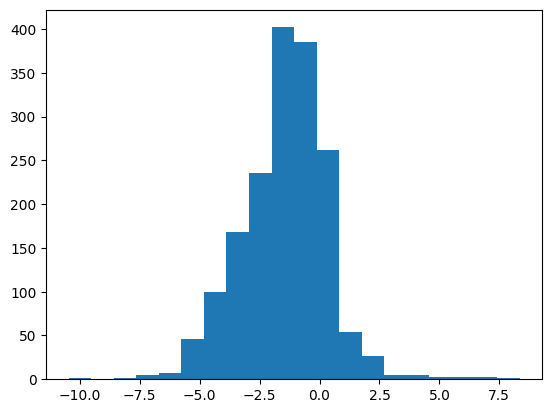

In [228]:
plt.hist(preds[:, 2], bins=20)
plt.show()

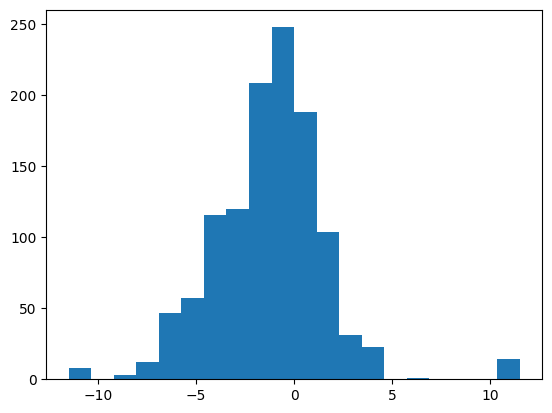

In [227]:
plt.hist(targets[:, 2], bins=20)
plt.show()

In [224]:
print(f"R2 Absorption max: {r2(preds[:, 0], targets[:, 0])}")
print(f"R2 Emission max: {r2(preds[:, 1], targets[:, 1])}")
print(f"R2 Log quantum yield: {r2(preds[:, 2], targets[:, 2])}")

R2 Absorption max: 0.80356365442276
R2 Emission max: 0.7671544551849365
R2 Log quantum yield: 0.09194207191467285


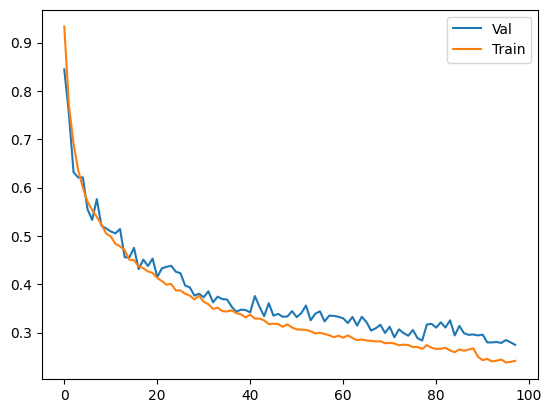

In [207]:
plt.plot(checkpoint['val_loss_history'], label='Val')
plt.plot(checkpoint['train_loss_history'], label='Train')
plt.legend()
plt.show()

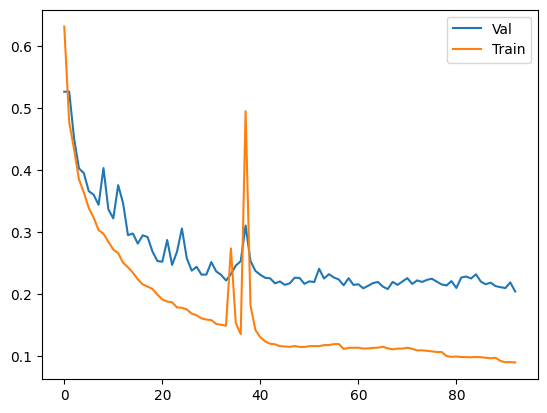

In [287]:
plt.plot(checkpoint['val_loss_history'], label='Val')
plt.plot(checkpoint['train_loss_history'], label='Train')
plt.legend()
plt.show()